## Dataset used : <a href="https://www.kaggle.com/binhminhs10/food5k">Food 5K</a>

The data is downloaded, unzipped.

In [1]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

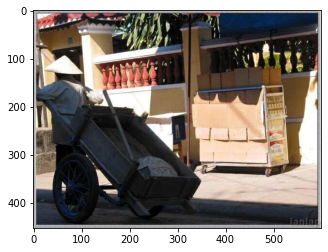

In [3]:
plt.imshow(image.load_img('training/0_102.jpg'))
plt.show()

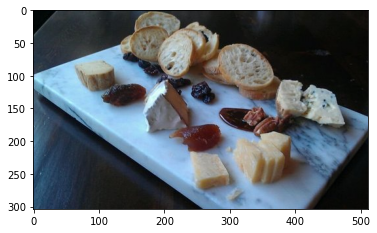

In [4]:
plt.imshow(image.load_img('training/1_102.jpg'))
plt.show()

## Restructuring Folders
Change the '\' to '/' based on OS

In [8]:
!mkdir data
!mkdir data\train
!mkdir data\test
!mkdir data\train\nonfood
!mkdir data\train\food
!mkdir data\test\nonfood
!mkdir data\test\food

In [10]:
!cp training/0*.jpg data\train\nonfood
!cp training/1*.jpg data\train\food
!cp validation/0*.jpg data\test\nonfood
!cp validation/1*.jpg data\test\food

## Main Program Begins

In [22]:
from glob import glob

IMAGE_SIZE = [200, 200]
train_path = 'data/train'
test_path = 'data/test'

# list of files
image_files = glob(train_path + "/*/*.jpg")
test_files  = glob(test_path + "/*/*.jpg")

# to determine number of classes
folders = glob(train_path + "/*")

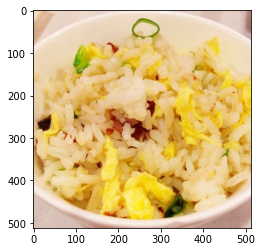

In [23]:
import numpy as np

plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

### Model Creation

In [29]:
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

ptm = PretrainedModel(
    input_shape= IMAGE_SIZE + [3],# 3 colour channels
    weights = 'imagenet', #  Direct it to dowload weights of imagenet dataset, or the model will be initialised randomly
    include_top = False  # We only get the core VGG, not the last Dense layer
)

ptm.trainable = False  # freeze the pre trined weights

K = len(folders)  # number of classes
x = Flatten()(ptm.output)
x = Dense(K, activation='softmax')(x)

In [30]:
model = Model(inputs = ptm.input, outputs = x)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)      

Image Data Generator generates data that can be directly validated using softmax, so we use that instead
of sigmoid.

In [35]:
gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

batch_size = 24

train_generator = gen.flow_from_directory(
    train_path,
    shuffle=True,
    target_size=IMAGE_SIZE,
    batch_size=batch_size
)

test_generator = gen.flow_from_directory(
    test_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size
)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [36]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [37]:
r = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    steps_per_epoch = int(np.ceil(len(image_files)/batch_size)),
    validation_steps = int(np.ceil(len(test_files)/batch_size))
)

Epoch 1/10
2/2 [==============================] - 11s 6s/step - loss: 2.7924 - accuracy: 0.9375 - val_loss: 0.3020 - val_accuracy: 0.9583
Epoch 2/10
2/2 [==============================] - 10s 5s/step - loss: 0.2064 - accuracy: 0.9792 - val_loss: 0.3741 - val_accuracy: 0.9792
Epoch 3/10
2/2 [==============================] - 10s 5s/step - loss: 2.1892 - accuracy: 0.9375 - val_loss: 2.4180 - val_accuracy: 0.9583
Epoch 4/10
2/2 [==============================] - 12s 6s/step - loss: 1.0373 - accuracy: 0.9375 - val_loss: 1.9805 - val_accuracy: 0.9167
Epoch 5/10
2/2 [==============================] - 12s 6s/step - loss: 1.1082 - accuracy: 0.9792 - val_loss: 2.5589 - val_accuracy: 0.9375
Epoch 6/10
2/2 [==============================] - 11s 6s/step - loss: 0.1182 - accuracy: 0.9792 - val_loss: 2.3399 - val_accuracy: 0.9167
Epoch 7/10
2/2 [==============================] - 11s 5s/step - loss: 1.4342 - accuracy: 0.9583 - val_loss: 0.1740 - val_accuracy: 0.9792
Epoch 8/10
2/2 [==================

Steps per epoch should be : int(np.ceil(len(image_files)/batch_size))<br>
Validation steps should be : int(np.ceil(len(test_files)/batch_size))
<br><br>
I took the value 2 to save resources and time 😅

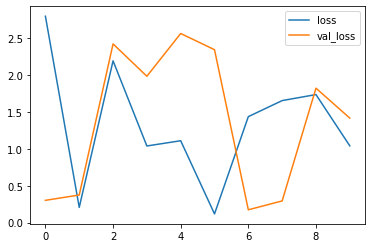

In [39]:
history = r.history
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend()
plt.show()